# 1. Installing required packages

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
!pip install ptable

In [ ]:
!pip install fuzzywuzzy

In [ ]:
! pip install contractions

# 2. Importing required packages

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
import re
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import string
from wordcloud import WordCloud
import spacy
from spacy.matcher import Matcher
import plotly.express as px
from prettytable import PrettyTable
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np # linear algebra
import pandas as pd 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
import nltk
nltk.download("all")
from nltk.corpus import stopwords as sw
from wordcloud import WordCloud, STOPWORDS

# Reading all files

In [ ]:
episodes = pd.read_csv('../input/chai-time-data-science/Episodes.csv',parse_dates=['recording_date','release_date'])
youtube_thumbnails = pd.read_csv('../input/chai-time-data-science/YouTube Thumbnail Types.csv')
anchor_thumbnails = pd.read_csv('../input/chai-time-data-science/Anchor Thumbnail Types.csv')
description = pd.read_csv('../input/chai-time-data-science/Description.csv')

In [ ]:
def conv_to_sec(time):
    """ Time to seconds """
    
    t_list = time.split(':')
         
    if(len(t_list) == 2):
        m = t_list[0]
        s = t_list[1]
        time_sec = (int(m)*60 + int(s))
    else:
        h = t_list[0]
        m = t_list[1]
        s = t_list[2]
        time_sec = (int(h)*60*60 + int(m)*60 + int(s)) 
    
    return time_sec


def add_columns(sub, episode_id):
    """ Transform the transcript of the given episode """
    
    # create the time second feature that converts the time into the unified qty. of seconds
    sub['Time_sec'] = sub['Time'].apply(conv_to_sec)
    
        
    # providing an identity to each transcript
    sub['Episode_Id'] = episode_id
    sub = sub[['Episode_Id', 'Time', 'Time_sec',  'Speaker', 'Text']]
    
    return sub

def get_all_texts(path):
    """ Combine all the 75 transcripts of the ML Heroes Interviews together as one dataframe """
    
    episodes = []
    for i in range(1,76):
        name = 'E'+str(i)
        csv_file = name +'.csv'
        try:            
            sub_epi = pd.read_csv(os.path.join(path, csv_file))            
            sub_epi = add_columns(sub_epi, (name))            
            episodes.append(sub_epi)            
        except:            
            continue
            
    return(pd.concat(episodes, ignore_index=True))

# create the combined transcript dataset
path = "../input/chai-time-data-science/Cleaned Subtitles"
record_texts = get_all_texts(path)
record_texts.head(5)

# Preliminary Analysis

In [ ]:
episodes.describe(include="all").T #transpose is used so that we can view all columns

> ***Points to Note***

* 85 episodes - 74 Episodes with ML Heroes, 9 Learning sessions, 1 kick off episode and 1 birthday special. Robert Bracco, Edouard Harris and Shivam Bansal appeared twice. Two interviews were hosted with multiple heroes in a podcast.
* Learning sessions start with M* series in episode_id, while the episodes start with E*.
* First release date is 21-07-2019 and last release date is 18-06-2020 (as per the given dataset), which makes it 10 months and 29 days( or 334 days).
* Most ML Heroes are currently located in USA and USA is top nationality for heroes.
* Most heroes interviewed are from 'Industry' category.
* Most of recording time is in the night, we can say right off the bat - it is very likely because most of heroes are from USA.
* Youtube subscribers cumulative sum is around 1K, while on the actual Youtube the number is 1.9K (checked on 08-Jul). It is likely that the subscribers are added from other networking sources that Mr.Sanyam Bhtani has and other communities that he is part of.
* "Chaitimedatascience" has been catering to multiple audience across multiple platforms/channels which is a big plus, placed in a unique spot to reach greater reach and heights.
* Produced 75.55 hours of viewing content (including the learning content) in a span of 334 days in 48 weeks (approx). This means 1.6 hour of watching content a week.
* CTDS has been churning out 1.77 episodes per week. (85 episodes released in 48 weeks)
* A cumsum of Youtube views is at 43616, Spotify streams is at 6720, Spotify listeners is at 5455, Apple listeners is at 1714. Viewership/Listenership has reached around 55+K, which is a good celebratory mark.
* Youtube seems to be way ahead of the pack, followed by Spotify and Apple.
* Interestingly, the average apple listening time have been 28.63 minutes, while the average anchor plays has been 8.77 minutes and youtube average viewing time has been 5.29 minutes. Net-Net - 'Listening time' has been more than the 'Viewing time'.
* Female to Male ratio is 12:88 (Male =65, Female =9). 
* Heroes from 21 nationalities were interviewed, which is a good diverse spread, however half of countries (ie. 11 countries) have only 1 hero interviewed from their country.
* A bulk of heroes  (ie. 37 heroes) are currently located in US. Many heroes could have migrated to the US. It could be because US has far more research opportunities, is spearheading DL/ML fields and has related job openings.
* Flavor of Tea - Masala Chai, Ginger Chai seems to be topping the chart with 16 each.








# Analyzing Episode title and description

In [ ]:
#Separating the interview episodes and the learning series
description_bool = description['episode_id'].str.startswith('E')
episode_bool = episodes['episode_id'].str.startswith('E')
l_episode_bool = episodes['episode_id'].str.startswith('M')

desc = description[description_bool]
just_episodes = episodes[episode_bool]
just_learning_episodes = episodes[l_episode_bool]

In [ ]:
#pre processing methods
def clean_the_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    # Expanding Contractions eg. i've to I have
    text = contractions.fix(text)
    text = re.sub(r".*native.*\n?","",text)    
    text = re.sub('Hey.+science.', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
          
    text = re.sub(r".*Audio.*\n?","",text)    
    text = re.sub(r".*sanyambhutani.com.*\n?","",text)
    text = re.sub(r".*Newsletter.*\n?","",text)
    text = re.sub(r".*so much.*\n?","",text)
    text = re.sub(r".*Sanyam Bhutani:.*\n?","",text)
    text = re.sub(r".*Subscribe.*\n?","",text)
    text = re.sub(r".*twitter.*\n?","",text)
    text = re.sub(r".*Flow.*\n?","",text)
    text = re.sub(r".*Follow.*\n?","",text)
    text = re.sub(r".*Playlist.*\n?","",text)
    text = re.sub(r".*support.*\n?","",text)
    text = re.sub(r".*Linkedin.*\n?","",text)
    text = re.sub(r".*Kaggle:.*\n?","",text)
    text = re.sub(r".*hosted.*\n?","",text)
    text = re.sub(r"interview[s|ed|ing]","",text,re.IGNORECASE)
    text = re.sub(r".*track.*\n?","",text)
    text = re.sub(r".*available.*\n?","",text)
    text = re.sub(r".*Blog.*\n?","",text)
    text = re.sub(r".*Correction.*\n?","",text)
    text = re.sub(r".*Note.*\n?","",text)
    text = re.sub(r".*About.*\n?","",text)
    #text = re.sub(r".*YouTube.*.?","",text)
    text = re.sub(r".*lazy.*\n?","",text)
   
    #text = re.sub(r".*find.*.?","",text)
    text = re.sub(r".*Link[s].*\n?","",text)
    text = re.sub(r".*KaggleDaysMeetup.*\n?","",text)
    
    text = re.sub('\n', ' ', text)
    text = text.lower()
    text = re.sub(r"enjoy","",text)
    text = re.sub(r"show","",text)
    text = re.sub(r"even","",text)
    text = re.sub(r"another","",text)
    text = re.sub(r"time","",text)
    text = re.sub(r"part","",text)
    text = re.sub(r"sanyam","",text)
    text = re.sub(r"episode","",text)
    text = re.sub(r"interview","",text)
    text = re.sub(r"bhutani","",text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_the_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    common_words = set(['sure','everyone','chai','us','also','hello','find','check','currently','two','description','welcome','podcast','many','like','get','lot','please','hi','heres','really','one'])
    stop_wds = common_words.union(sw.words('english'))
    remove_stopwords = [w for w in tokenized_text if w not in stop_wds]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [ ]:
# Cleaning description to include only the guest details and counting the words and plotting 
desc['processed_description'] = desc['description'].apply(str).apply(lambda x: text_preprocessing(x))
desc["description_len"] = desc['processed_description'].map(lambda x : len(x.split(" ")))

just_episodes["title_length"] = just_episodes["episode_name"].apply(lambda x: len(x.split()))
fig, ax = plt.subplots()
_ = ax.scatter(x=just_episodes['youtube_views'], y=just_episodes['title_length'],  edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Youtube Views", ylabel="Title Length (in words)")

result = pd.merge(desc, just_episodes, on=['episode_id'])
fig, ax = plt.subplots()
_ = ax.scatter(x=result['youtube_views'], y=result['description_len'],  edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Youtube Views", ylabel="Description Length (in words)")

In [ ]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("<b>Description Length over episodes</b>","<b></b>"))
fig.append_trace(go.Scatter(name='<b>Description Length</b>', x=desc.episode_id, y=desc.description_len, marker_color='rgb(0, 102, 57)'), row=1, col=1),
#fig.append_trace(go.Scatter(name='<b>Episode Duration</b>', x=just_episodes.episode_id, y=just_episodes.youtube_views, marker_color='rgb(100, 17, 53)'), row=2, col=1),
fig.update_layout(height=400, width=800, legend_orientation="h", plot_bgcolor='rgb(255,255,255)')
fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)
fig.show()

In [ ]:
print("Mean episode duration is {} minutes.".format(round(just_episodes['episode_duration'].mean()/60)))

sorted_episodes = just_episodes.sort_values('youtube_views', ascending=False)
high_viewed_episodes = sorted_episodes[:10]
high_viewed_episodes = high_viewed_episodes[['episode_id','heroes','heroes_gender', 'episode_duration','youtube_views']]
#print(high_viewed_episodes)
print("Average Duration for highly viewed episodes is {} minutes ".format(round(high_viewed_episodes['episode_duration'].mean()/(60))))

less_viewed_episodes = sorted_episodes[-9:]
less_viewed_episodes = less_viewed_episodes[['episode_id','heroes','heroes_gender', 'episode_duration','youtube_views']]
#print(less_viewed_episodes)
print("Average Duration for less viewed episodes is {} minutes  ".format(round(less_viewed_episodes['episode_duration'].mean()/(60))))

> Points to note:
* Description is cleaned to not include links, and just include guest details/introduction
* We can see that there is not much effect on views based on title or description length
* Description length has not been consistent over the episodes.
* Suggestion - Description can be catchy, also verbose including more details about what was discussed in the interview. This will excite the viewer to watch the episode.
* For example - Andrew Lukyaneko's episode description boils down to following keywords - [king, kaggle, kernels, grandmaster, andrew, lukyanenko, ranked, journey, data, science, talk, pipeline, writing, kernels"] and James Dellinger's episode description boils down to following keywords - [james, dellinger, experiments, dali, library, nvidia, talk, performance, convenience, comparisons, frameworks, others]
* Rohan Rao's episode had one of longest description - [kaggle, grand master, data scientist, rohan rao, rohan kaggle, grand master, competition, tier, data scientist, represented, india, data science, sudoku, puzzles, current, national sudoku champion first indian ranked top world championship, secured eighth position world rank secured, podium, finishes, asian, sudoku, championship, five national puzzle champion, current rank four current national sudoku champion talk journey data science data numbers, his journey, world competitive sports kaggle journey, discuss data science journey, kaggle, discuss approach kaggle changed years evolved current thoughts, platform tips advice discuss recent eighth gold medal, kaggle teams, second position finish, ashrae great energy, prediction, cpmp, pos solution, rohan rao]
* Highly viewed episodes are longer in duration than the the less viewed episodes. There is a good 20 minutes difference between average high-viewed and less-viewed episodes. Does it mean the longer the episode, the more it is viewed ? We will look at further analysis.

# Analyzing the Questions asked, number of questions

**ABOUT THE NEW DATASET - TALK**

Contains data about the host and guest interactions

* episode_id : Episode ID
* num_questions : Number of questions asked by the host
* num_conversations : Number of times the host spoke/interacted
* qc_percentage : num_questions / num_conversations
* questions_asked : Actual questions asked
* guest_introduction : subtitle of guest_introduction
* humoring_words_used : These words allow the guest to have a welcoming, easy going environment to open up and share stories. Humoring mean obliging, compliant, amiable, pampering, allowing. It is different from humor we know.
* host_talk : host's conversations
* guest_talk : guest's conversations
* abstract : abstracts

In [ ]:
# We are counting specific words in the host subtitles
def humoring_words_count(all_host_text):
    words = 0
    humoring_words = ['Awesome','cool',' ha ','Got it','Great','fan','amazing']
    for i in range(len(humoring_words)):
        words += all_host_text.count(humoring_words[i])
    return words    
    
episodes = []
num_questions = []
num_conversations = []
qc_percentage = []
questions_asked = []
humoring_words_used = []
hosts_talk = []
guests_talk = []
guest_introduction = []

for episode_id in list(record_texts['Episode_Id'].unique()):        
    if (episode_id !='E69' and episode_id !='E0' ):        
        episode = record_texts[record_texts['Episode_Id'] == episode_id]        
        host_talk = episode[episode['Speaker']=='Sanyam Bhutani']
        guest_talk = episode[episode['Speaker']!='Sanyam Bhutani'] 
        no_of_conversations = host_talk.shape[0]
        all_host_text = ' '.join(host_talk['Text'])
        all_guest_text = ' '.join(guest_talk['Text'])
        
        episodes.append(episode_id)        
        
        no_of_questions = all_host_text.count('?')
        num_questions.append(no_of_questions)
        num_conversations.append(no_of_conversations)
        qlist = re.findall(r'\b([a-zA-Z][^.!]*[?])',all_host_text)
        qstring = ' '.join(str(e) for e in qlist)
        questions_asked.append(qstring)
        qc_percentage.append(round((no_of_questions/no_of_conversations )* 100))
        humoring_words_used.append(humoring_words_count(all_host_text))
        hosts_talk.append(all_host_text)
        guests_talk.append(all_guest_text)        
        guest_introduction.append(host_talk['Text'][0:2].values[0])
        
    else:
        continue
        

# make the dataframe
talk = pd.DataFrame({
    'episode_id': episodes,
    'num_host_questions': num_questions,
    'num_host_conversations': num_conversations,    
    'qc_percentage': qc_percentage,
    'questions_asked':questions_asked,
    'guest_introduction': guest_introduction,
    'humoring_words_used': humoring_words_used  ,
    'host_talk': hosts_talk,
    'guest_talk': guests_talk    
})

talk['guest_introduction_processed'] = talk['guest_introduction'].apply(str).apply(lambda x: text_preprocessing(x))

In [ ]:
print("Average Question-to-Conversation ratio is {}".format(round(talk['qc_percentage'].mean())))

sorted_talks = talk.sort_values('qc_percentage', ascending=False)
sorted_talks.head(3)

In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("<b>Number of Questions Asked</b>", "<b>Episode Duration</b>","<b>Number of Humouring Words used</b>"))

fig.append_trace(go.Scatter(name='<b>Questions Asked</b>', x=talk.episode_id, y=talk.num_host_questions, marker_color='rgb(0, 102, 57)'), row=1, col=1),
fig.append_trace(go.Scatter(name='<b>Episode Duration</b>', x=just_episodes.episode_id, y=just_episodes.episode_duration, marker_color='rgb(100, 17, 53)'), row=2, col=1),
fig.append_trace(go.Scatter(name='<b>Humouring Words</b>', x=talk.episode_id, y=talk.humoring_words_used, marker_color='rgb(0, 200, 157)'), row=3, col=1),

fig.update_layout(height=800, width=900, legend_orientation="h", plot_bgcolor='rgb(255,255,255)')
fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)
fig.show()

* Episode - E0 is a short "Introduction" episode of 157 seconds. 
* Episode - E74 is an empty one. So the questions are 0.

* Highest number of questions were asked in Rohan Rao's episode (54 questions), followed by E17 (48 questions).
* Lowest number of questions were asked in Jean Francois Puget's episode (7 questions), Vladimir Iglovikov's episode (11 questions).
* Shivam Bansal's episode had most number of humoring words used (30 times) and Julien Chaumond	is the next (27 times). Surprisingly, Shivam Bansal's episode was the shortest episode with 17.5 minutes.
* Pierre Stock's episode and Sergey Kolesnikov's episode had least number of humoring words used (just once).  Surprisingly, Pierre Stock's episode is 47 minutes long and Sergey's episode is 1.25 hours long (considering that mean episode duration is 59 minutes.)!
* Question-to-conversation ratio ranges from 27% to whopping 132%, with a mean qc ratio at 67%. 
* Sanyam has been an extremely curious host in the following episodes - Rohan Rao (asking 37 questions in 28 times he spoke), David Foster (asking 40 questions in 31 interactions), Navdeep Gill (asking 31 questions in 27 interactions), Ines Montani (asking 40 questions in 36 interactions)
* Sanyam was an avid listener (read he let the guest speak ) in the following episodes - Eugene Khvedchenya	and Jean Francois Puget	 (at qc ratio of 27 %).
* There is no direct correlation between number of questions asked or number of welcoming/encouraging words used and youtube subscribers/views counts.
* Nevertheless, we will keep exploring and digging deeper.
* Looking at the 'questions_asked' the standard questions are - 
   *  a. Could you tell us what got you interested in datascience? 
   * b. So what would lead you to first signing up for kaggle and getting into the first competition? 
   * c. How does Kaggle blend/balance along with your full time job? 
   * d. How do you approach a new problem?
   * e. What are your best tips for a beginner who\'s just getting started and dreams of getting a Kaggle gold? 
   * f. Could you tell us what does a day look like for a researcher? 
   * g. What sort of challenges are you interested in today?
   * h. What problems are you currently working on?
   * i. What would be the best platforms to follow you and follow your work?




# Analysing Introduction

Why is an introduction is important?

* It makes your audience excited for who they are about to see
* It makes the speaker feel genuinely acknowledged for being invited to that event

> Without a good introduction, the audience will not have a strong enough reason to be open to the speaker’s ideas because they might not know the credibility of the speaker.

In [ ]:
# Cleaning the text
talk['guest_introduction_processed'] = talk['guest_introduction'].apply(str).apply(lambda x: text_preprocessing(x))

# We will look at Frequency Distribution of words used in introduction
guest_intro = []
for s in talk['guest_introduction_processed']:
    guest_intro.append(sent_tokenize(s))   

gi_string = ''.join(str(gi) for gi in guest_intro)
gi_string = re.sub('[^a-zA-Z]', ' ', gi_string )
gi_tokenized_word = nltk.word_tokenize(gi_string)

gi_fdist = FreqDist(gi_tokenized_word)
print(gi_fdist.most_common(100))

%matplotlib inline
gi_fdist.plot(30, cumulative=False,title = "Common words used in guest introduction")
plt.show()

**We can infer that - Sanyam is setting a context for the interviews, that he will talk about Kaggle competitions competed, journey to data science, research in machine learning, experiences in this field and amazing community that we have.** 

# Analyzing Guest responses/answers

Questions to ponder on:
* How are the guests responding ? 
* Are they going off the tangent ? 
* Are they brief and concise? 
* Are they bringing personable/relatable account?

Let us look at how spacy library brings out the word matching. It would be disservice if spacy is not used in our EDA, especially because we have Ines Montani as one of our guests (Co_founder at Explosion - spaCY) :)

In [ ]:
# We are using spacy to match words
nlp = spacy.load('en_core_web_lg')

def clean_by_spacy(text):
    url_reg  = r'[a-z]*[:.]+\S+'
    text   = re.sub(url_reg, '', text)
    noise_reg = r'\&amp'
    text   = re.sub(noise_reg, '', text)
    return text

cleaned_text = nlp(clean_by_spacy(talk['guest_talk'][55]))#Mark Landry	E57
matcher = Matcher(nlp.vocab)
matched_sents = [] # collect data of matched sentences to be visualized

def collect_sents(matcher, doc, i, matches, label='MATCH'):
    """
    Function to help reformat data for displacy visualization
    """
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span
    
    # append mock entity for match in displaCy style to matched_sents
    
    if doc.vocab.strings[match_id] == 'ADVICE':  
        match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'ADVICE'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })
       
    elif doc.vocab.strings[match_id] == 'STORY':  
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'STORY'}]        
        matched_sents.append({'text': sent.text, 'ents': match_ents })
        
    elif doc.vocab.strings[match_id] == 'KAGGLE': 
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'KAGGLE'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })        
        
    elif doc.vocab.strings[match_id] == 'IDEA':  
        match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'IDEA'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })
        
    elif doc.vocab.strings[match_id] == 'CHALLENGE':  
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'CHALLENGE'}]        
        matched_sents.append({'text': sent.text, 'ents': match_ents })
        
    elif doc.vocab.strings[match_id] == 'PROJECT':  
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'PROJECT'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })          
    
# declare different patterns
advice_pattern = [{'LOWER': 'advice'}, {"IS_ALPHA": True} ]
story_pattern = [{'LOWER': 'story'}, {"IS_PUNCT": True}]
kaggle_pattern = [{'LOWER': 'kaggle'}, {"IS_PUNCT": True}]
idea_pattern = [{'LOWER': 'idea'}, {"IS_PUNCT": True} ]
challenge_pattern = [{'LOWER': 'challenge'}, {"IS_PUNCT": True}]
project_pattern = [{'LOWER': 'project'}, {"IS_PUNCT": True}]

matcher.add('ADVICE', collect_sents, advice_pattern)  # add pattern
matcher.add('STORY', collect_sents, story_pattern)  # add pattern
matcher.add('KAGGLE', collect_sents, kaggle_pattern)  # add pattern
matcher.add('IDEA', collect_sents, idea_pattern)  # add pattern
matcher.add('CHALLENGE', collect_sents, challenge_pattern)  # add pattern
matcher.add('PROJECT', collect_sents, project_pattern)  # add pattern

matches = matcher(cleaned_text)
spacy.displacy.render(matched_sents, style='ent', manual=True, jupyter=True,  
                      options = {'colors': {'STORY': '#ded1e8', 'ADVICE': '#cc2936', 'KAGGLE':'#f2cd5d','IDEA': '#5290c8', 'CHALLENGE': '#cb9936', 'PROJECT':'#d27571'}})
print("Matched Sentences: ",matched_sents)

In [ ]:
cleaned_text = nlp(clean_by_spacy(talk['guest_talk'][48]))#Walter Reade E50
matcher = Matcher(nlp.vocab)
matched_sents = [] # collect data of matched sentences to be visualized

def collect_sents(matcher, doc, i, matches, label='MATCH'):
    """
    Function to help reformat data for displacy visualization
    """
   
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span
    
    # append mock entity for match in displaCy style to matched_sents
    
    if doc.vocab.strings[match_id] == 'ADVICE':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'ADVICE'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })
       
    elif doc.vocab.strings[match_id] == 'STORY':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'STORY'}]        
        matched_sents.append({'text': sent.text, 'ents': match_ents })
        
    elif doc.vocab.strings[match_id] == 'KAGGLE':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'KAGGLE'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })        
        
    elif doc.vocab.strings[match_id] == 'IDEA':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'IDEA'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })
        
    elif doc.vocab.strings[match_id] == 'CHALLENGE':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'CHALLENGE'}]        
        matched_sents.append({'text': sent.text, 'ents': match_ents })
        
    elif doc.vocab.strings[match_id] == 'PROJECT':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'PROJECT'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })          
    
# declare different patterns
advice_pattern = [{'LOWER': 'advice'}, {"IS_ALPHA": True} ]
story_pattern = [{'LOWER': 'story'}, {"IS_PUNCT": True}]
kaggle_pattern = [{'LOWER': 'kaggle'}, {"IS_PUNCT": True}]
idea_pattern = [{'LOWER': 'idea'}, {"IS_PUNCT": True} ]
challenge_pattern = [{'LOWER': 'challenge'}, {"IS_PUNCT": True}]
project_pattern = [{'LOWER': 'project'}, {"IS_PUNCT": True}]

matcher.add('ADVICE', collect_sents, advice_pattern)  # add pattern
matcher.add('STORY', collect_sents, story_pattern)  # add pattern
matcher.add('KAGGLE', collect_sents, kaggle_pattern)  # add pattern
matcher.add('IDEA', collect_sents, idea_pattern)  # add pattern
matcher.add('CHALLENGE', collect_sents, challenge_pattern)  # add pattern
matcher.add('PROJECT', collect_sents, project_pattern)  # add pattern

matches = matcher(cleaned_text)
spacy.displacy.render(matched_sents, style='ent', manual=True, jupyter=True,  
                      options = {'colors': {'STORY': '#ded1e8', 'ADVICE': '#cc2936', 'KAGGLE':'#f2cd5d','IDEA': '#5290c8', 'CHALLENGE': '#cb9936', 'PROJECT':'#d27571'}})
print(matched_sents)

**We looked at Walter Reade and Mark Landry's responses, which are full of advice/inspiration, emotions around stories. Such kind of content makes for a feel good podcast.**

**TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the documents. This method is a widely used technique in Information Retrieval and Text Mining.
Let us apply this to guest talks to find out what are rarer words that are important.**

In [ ]:
#https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
corpus = talk['guest_talk'].values

stop_words = set(sw.words('english'))
common_words = ['people','amazing','lot','obviously','often','hours','yeah','think','may','hero','guess','super','gonna','link','also','say','couple','let','science','like','usually','really','kind','first','certain','um','episode','Length','podcast','chai','sanyam','bhutani','playlist','Name','audio','version','here','available','episod','list','description']
all_stop_words = stop_words.union(set(common_words))

cv = CountVectorizer(max_df=0.7,stop_words = all_stop_words, analyzer='word', min_df=1,max_features=None, ngram_range=(1,3))
X = cv.fit_transform(corpus)
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True,sublinear_tf=False, norm=None)
tfidf_transformer.fit(X)

# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc = " ".join(talk['guest_talk'])
#print((doc))

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn] 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]    
    return results

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top 30
keywords=extract_topn_from_vector(feature_names,sorted_items,30)
 
# now print the results
print("\nFollowing are 30 Keywords: "," ".join(keywords))
#for k in keywords:
    #print(k,keywords[k])    

**One can see that all the above keywords were key points of discussion in the episodes.**

# Case for Diversity

Points to ponder over:
* How are women faring ?
* How about including more interviewees from other nationalities ?
* How about including more interviewees from newer nationalities ?
* How about including more from African backgrounds ? ('Black Lives matter')

In [ ]:
print("Ratio of Women-to-Men heroes is ",just_episodes.groupby('heroes_gender')['episode_id'].count()[0]/(just_episodes.groupby('heroes_gender')['episode_id'].count()[0] + just_episodes.groupby('heroes_gender')['episode_id'].count()[1]))
print("Ratio of Women-to-Men Youtube Views is",just_episodes.groupby('heroes_gender')['youtube_views'].sum()[0]/(just_episodes.groupby('heroes_gender')['youtube_views'].sum()[0]+just_episodes.groupby('heroes_gender')['youtube_views'].sum()[1]))
print("Ratio of Women-to-Men Youtube Subscribers is",just_episodes.groupby('heroes_gender')['youtube_subscribers'].sum()[0]/(just_episodes.groupby('heroes_gender')['youtube_subscribers'].sum()[0]+just_episodes.groupby('heroes_gender')['youtube_subscribers'].sum()[1]))
print("Ratio of Women-to-Men Youtube Non Impression Views is",just_episodes.groupby('heroes_gender')['youtube_nonimpression_views'].sum()[0]/(just_episodes.groupby('heroes_gender')['youtube_nonimpression_views'].sum()[0]+just_episodes.groupby('heroes_gender')['youtube_nonimpression_views'].sum()[1]))
print("Ratio of Women-to-Men Youtube Impression Views is",just_episodes.groupby('heroes_gender')['youtube_impression_views'].sum()[0]/(just_episodes.groupby('heroes_gender')['youtube_impression_views'].sum()[0]+just_episodes.groupby('heroes_gender')['youtube_impression_views'].sum()[1]))
print("Ratio of Women-to-Men Youtube Click-Through-Rate is",just_episodes.groupby('heroes_gender')['youtube_ctr'].sum()[0]/(just_episodes.groupby('heroes_gender')['youtube_ctr'].sum()[0]+just_episodes.groupby('heroes_gender')['youtube_ctr'].sum()[1]))
print("Ratio of Women-to-Men Apple listeners is",just_episodes.groupby('heroes_gender')['apple_listeners'].sum()[0]/(just_episodes.groupby('heroes_gender')['apple_listeners'].sum()[0]+just_episodes.groupby('heroes_gender')['apple_listeners'].sum()[1]))
print("Ratio of Women-to-Men Spotify listeners is",just_episodes.groupby('heroes_gender')['spotify_listeners'].sum()[0]/(just_episodes.groupby('heroes_gender')['spotify_listeners'].sum()[0]+just_episodes.groupby('heroes_gender')['spotify_listeners'].sum()[1]))

In [ ]:
print("YT Subscribers that channel has earned - grouped by nationality ",just_episodes.groupby('heroes_nationality')['youtube_subscribers'].sum())
print("YT Views that episodes have garnered - grouped by nationality ",just_episodes.groupby('heroes_nationality')['youtube_views'].sum())
print("YT Subscribers that channel has earned - grouped by location ",just_episodes.groupby('heroes_location')['youtube_subscribers'].sum())
print("YT Views that episodes have garnered - grouped by location ",just_episodes.groupby('heroes_location')['youtube_views'].sum())

**Points to Note:**
* Clearly, female heroes are bringing more traffic in youtube medium. 
* More heroes can be picked from countries such as India, Australia, France, Germany, Austria, UK, Russia, Ukraine, Brazil, Canada. These heroes would have been local heroes in their home countries, airing their heroes would add more viewers/listeners to our youtube/podcast numbers.
* We can also include newer countries with high population like China, Indonesia, Pakistan, Nigeria, Bangladesh and Mexico.
* Going by Kaggle Survey 2019 - Countries like Egypt, Iran and Romania has highest proportion of data scientists working in ML/DL
* We can also include different profiles like early bloomers (below 20 years of age), late starters (above 50 years of age)
* We can consider profiles of career transitioners - dancer/skater/priest --> data scientist
* We can consider profiles of turnarounds - from bad coder to grandmaster


# Looking at Fast.ai Series

In [ ]:
just_learning_episodes[['episode_id','release_date','youtube_subscribers','youtube_likes','youtube_comments','youtube_impression_views','youtube_views','youtube_avg_watch_duration','apple_avg_listen_duration','apple_listeners','spotify_listeners']]

**Observations:**
* 9 fastai lecture recap(also takeaways and Jeremy's advice) was released on 07-Mar-2020. 
* The youtube_subscribers gained from  these videos are not much to talk about. 
* Apple average listening duration is more than the youtube watch duration. 
* But all the stats are low in general. 
* This is very niche in the sense - for fast.ai course learners

# Analyzing Emotions

* Emotion is more powerful than reason and emotions can be triggered. 
* The palette of human emotions can be assessed to attract the attention of your audience and make them want to learn more and perform the desired action – view, hear, like, comment, contribute, share or subscribe.
* They are: joy, surprise, trust, fear, anticipation, anger, sadness, and disgust.
* Ones relevant to us are - Trust, Anticipation, Surprise and Joy.


In [ ]:
#calculating most viewed and least viewed 10 episodes.
sorted_episodes = just_episodes.sort_values('youtube_views', ascending=False)
episodes_top10 = sorted_episodes[:10]
episodes_top10 = episodes_top10[['episode_id','heroes','heroes_gender','heroes_location', 'heroes_nationality','youtube_views']]
top_episode_ids = episodes_top10['episode_id']

bottom = sorted_episodes[-9:]
bottom = bottom[['episode_id','heroes','heroes_gender','heroes_location', 'heroes_nationality','youtube_views']]
low_episode_ids = bottom['episode_id']    

I am using dataset "NRC-Emotion-Intensity" from - 
https://saifmohammad.com/WebPages/AffectIntensity.htm

The words are lemma/stem based, so I am using fuzzywuzzy( >= 94) to choose closest words and get a count of 4 above mentioned emotions - anticipation, joy, trust, surprise.

**We are getting most viewed episodes and less viewed episodes and looking at their emotional appeal.**
**Below is  Plutchik’s Wheel of Emotions**

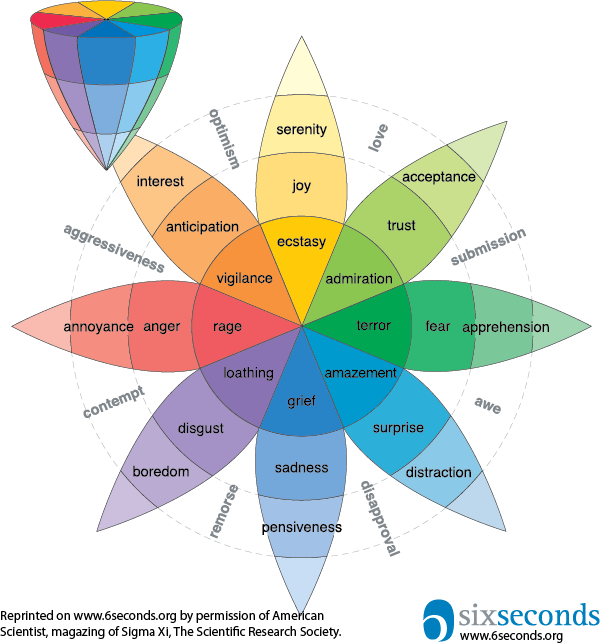

In [ ]:
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
emotion = pd.read_csv('../input/emodata/Emotion-Lexicon.txt', sep='\t')
first_run = False # Each run takes 75 minutes, so the dataframe is in pickl files.

if first_run == True:
    joy_array = []
    trust_array = []
    anticipation_array = []
    surprise_array = []
    episode_array = []
    token_array = []

    elements = emotion['word'].values
    sentences_emotions = []
    for id in top_episode_ids:
        print("-"*60)
        guest_talk = []
        
        sentences_emotions = []
    
        joy = 0
        trust = 0
        anticipation = 0
        surprise = 0
        tokens = 0
 
        chosen_talk = talk[talk['episode_id'] == id]
        guest_talk = " ".join(chosen_talk['guest_talk'])
        for word in tokenizer.tokenize(guest_talk.lower()):        
            sentences_emotions.append(word)
    
        tokens = len(sentences_emotions)    
        
        for (i, wd) in enumerate(sentences_emotions):
            for (j, element) in enumerate(elements):        
                if fuzz.ratio(element, wd) >= 94:            
                    if emotion['emotion'][j] == 'trust':
                        trust += 1
                    elif emotion['emotion'][j] == 'surprise':
                        surprise += 1
                    elif emotion['emotion'][j] == 'anticipation':
                        anticipation += 1
                    elif emotion['emotion'][j] == 'joy':
                        joy += 1
    
        episode_array.append(id)
        token_array.append(tokens)
        anticipation_array.append(anticipation)
        surprise_array.append(surprise)
        trust_array.append(trust)
        joy_array.append(joy)
        print("Episodes: ",episode_array)
        print("Num of Tokens: ",token_array) 
        print("Num of 'Anticipation': ",anticipation_array )
        print("Num of 'Surprise': ",surprise_array )
        print("Num of 'Trust': ",trust_array )
        print("Num of 'Joy': ",joy_array )
        print("="*60)

    # make the dataframe
    top_videos_emotions = pd.DataFrame({
        'episodes_array': episode_array,
        'num_tokens':token_array,
        'num_anticipation': anticipation_array,
        'num_surprise': surprise_array,
        'num_trust': trust_array,
        'num_joy': joy_array    
    })

    # display first 10 rows
    top_videos_emotions.head(2)
    pd.to_pickle(top_videos_emotions, "./top_videos_emotions.pkl")

In [ ]:
if first_run == True:    
    joy_array = []
    trust_array = []
    anticipation_array = []
    surprise_array = []
    episode_array = []
    token_array = []

    elements = emotion['word'].values
    sentences_emotions = []
    for id in low_episode_ids:
        print("-"*60)
        guest_talk = []        
        sentences_emotions = []
    
        joy = 0
        trust = 0
        anticipation = 0
        surprise = 0
        tokens = 0
 
        chosen_talk = talk[talk['episode_id'] == id]
        guest_talk = " ".join(chosen_talk['guest_talk'])
        for word in tokenizer.tokenize(guest_talk.lower()):        
            sentences_emotions.append(word)
    
        tokens = len(sentences_emotions)    
        
        for (i, wd) in enumerate(sentences_emotions):
            for (j, element) in enumerate(elements):        
                if fuzz.ratio(element, wd) >= 94:            
                    if emotion['emotion'][j] == 'trust':
                        trust += 1
                    elif emotion['emotion'][j] == 'surprise':
                        surprise += 1
                    elif emotion['emotion'][j] == 'anticipation':
                        anticipation += 1
                    elif emotion['emotion'][j] == 'joy':
                        joy += 1
    
        episode_array.append(id)
        token_array.append(tokens)
        anticipation_array.append(anticipation)
        surprise_array.append(surprise)
        trust_array.append(trust)
        joy_array.append(joy)
        print("Episodes: ",episode_array)
        print("Num of Tokens: ",token_array) 
        print("Num of 'Anticipation': ",anticipation_array )
        print("Num of 'Surprise': ",surprise_array )
        print("Num of 'Trust': ",trust_array )
        print("Num of 'Joy': ",joy_array )
        print("="*60)

    # make the dataframe
    min_videos_emotions = pd.DataFrame({
        'episodes_array': episode_array,
        'num_tokens':token_array,
        'num_anticipation': anticipation_array,
        'num_surprise': surprise_array,
        'num_trust': trust_array,
        'num_joy': joy_array    
    })

    # display first 10 rows
    min_videos_emotions.head(2)
    pd.to_pickle(min_videos_emotions, "./min_videos_emotions.pkl")

In [ ]:
def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=True, reverse=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if len(category_labels) != 0:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")
                
plt.figure(figsize=(12, 10))
series_labels = ['Anticipation', 'Trust','Surprise','Joy']

data = [
   unpickled_top_videos_emotions['num_anticipation'], 
    unpickled_top_videos_emotions['num_trust'],
    unpickled_top_videos_emotions['num_surprise'],
    unpickled_top_videos_emotions['num_joy']
]

category_labels = top_videos_emotions['episodes_array']

plot_stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    colors=['tab:orange', 'tab:green', 'tab:blue', 'tab:red'],
    y_label="Number of words"
)
plt.title('Emotional appeal of top episodes')
plt.savefig('top_episodes_emotions.png')
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
series_labels = ['Anticipation', 'Trust','Surprise','Joy']

data = [
   unpickled_min_videos_emotions['num_anticipation'], 
    unpickled_min_videos_emotions['num_trust'], 
    unpickled_min_videos_emotions['num_surprise'],
    unpickled_min_videos_emotions['num_joy']
]

category_labels = unpickled_min_videos_emotions['episodes_array']

plot_stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.1f}",
    colors=['tab:orange', 'tab:green', 'tab:blue', 'tab:red'],
    y_label="Number of words"
)

plt.savefig('bottom_episodes_emotions.png')
plt.show()

In [ ]:

if first_run != True:
    unpickled_top_videos_emotions = pd.read_pickle("../input/pklfiles/top_videos_emotions.pkl")
    print("Most Viewed Videos emotions: ",unpickled_top_videos_emotions.head(2))
    unpickled_min_videos_emotions = pd.read_pickle("../input/minpklfiles/min_videos_emotions.pkl")
    print("Least Viewed Videos emotions: ",unpickled_min_videos_emotions.head(2))

In [ ]:
table = PrettyTable() 
print('Comparison table of emotions across Most viewed & Least viewed YouTube Episodes')
table.add_column('Emotions',['Anticipation','Trust','Surprise','Joy'], align='l', valign='t')
table.add_column('Most Viewed Episodes',[round(unpickled_top_videos_emotions['num_anticipation'].mean()),round(unpickled_top_videos_emotions['num_trust'].mean()), round(unpickled_top_videos_emotions['num_surprise'].mean()), round(unpickled_top_videos_emotions['num_joy'].mean())],valign='b')
table.add_column('Least Viewed Episodes',[round(unpickled_min_videos_emotions['num_anticipation'].mean()),round(unpickled_min_videos_emotions['num_trust'].mean()), round(unpickled_min_videos_emotions['num_surprise'].mean()), round(unpickled_min_videos_emotions['num_joy'].mean())],valign='m')
print(table)

**Our Audience ranges from college graduates to experienced folks.
Why are these Emotions important in this context:
* Anticipation - ML/DS newbies/experienced who want to how to ace Kaggle competitions and looking for a break in these fields, find these interviews give them hope and expectation
* Surprise - Seeing how our heroes tackled issues and solved complex problems amazes us
* Trust - When there is faith, that connect is formed, audience seems to follow advice, tips, suggestion to better themselves.
* Joy - When we are enjoying what we are doing we don't seem to mind the time because we are in a "flow". Audience is glued to long interviews when heroes recount their truimphant, jubilant tales and that ecstacy is percolated down to the audience.**

Observations:
Episode E12 - One can say it went "off the road" as discussion steered around Unemployment, Free lancing, Travelling continents, Visa issues, boredom, effect on relationships etc.

# Analyzing Medium Blog Data

* I have collected data from the interview blogs and uploaded as csv. 
* I could not segregate the transcripts speaker wise due to paucity of time.
* I am not very sure of segregation of 'category'.
* Let us see what is the deal with the blog interviews. :)

In [ ]:
blog = pd.read_csv('../input/mediumblog1/sb_blog.csv', encoding='ISO-8859-1', parse_dates=['release_date'])
blog.head(5)

**Points to Note:**

**** Note: Blog interviews has 5 heroes who were interviewed for Podcast also - Tuatini Godard, Dr. Vladimir I. Iglovikov, Dr. Jean-Francois Puget, Mikel Bober-Irizar, Sylvain Gugger****

* One blog series i.e Blog Interview #12 is not available
* Diversity has been exemplified through these 24 blogs interviews be it- age, career transitions, parallel career, countries, work (full time/freelancers)
  * Age - Mikel is youngest grandmaster (17 years) and at the other extreme we have a very senior person - Mr.Leslie Smith as guest. 
  * Career transition - Christine McLeavey transitioned - From physics field to data science. 
  * Parallel careers  - Dr. Alexandre (Radiologist as well as Data Scientist)
  * Heroes hail from various countries. 
  * Freelancers (ex: Tuatini Godard) and Full time job holders (ex: S Rajkumar)

* Comments on blogs have been very low and there are no responses by "Sanyam Bhutani" to the comments.

In [ ]:
#preprocessing and counting word length of script and introduction
blog['script'] = blog['transcript'].apply(str).apply(lambda x: text_preprocessing(x))
blog['intro'] = blog['introduction'].apply(str).apply(lambda x: text_preprocessing(x))
blog['script_len'] = blog['script'].apply(str).apply(lambda x: len(x.split()))
blog['intro_len'] = blog['intro'].apply(str).apply(lambda x: len(x.split()))
blog

In [ ]:
print("Category vs Claps: ", blog.groupby('category')['claps'].sum())
print("\nRatio of Women-to-Men heroes is ",blog.groupby('heroes_gender')['heroes'].count()[0]/(blog.groupby('heroes_gender')['heroes'].count()[0] + blog.groupby('heroes_gender')['heroes'].count()[1]))


Points to Note:
* Guests from 'Industry'category have maximum applause (8.3K) followed by guests from 'Research' industry (2.5K) 
* Out of 24 interviews, only 2 were women. Hence the female-male guests ratio is very small at .083

In [ ]:
# Sorted by claps in descending order 
sorted_blog = blog.sort_values('claps', ascending=False)
plt.bar(sorted_blog['heroes'], sorted_blog['claps'])
plt.xlabel('Heroes', fontsize=15)
plt.ylabel('Claps', fontsize=15)
plt.xticks(sorted_blog['heroes'], fontsize=9, rotation=90)
plt.title('Heroes Vs Claps')
plt.figure(figsize=(20,15))
plt.show()

**Points to Note**:
* Vladimir, Pavel and Artur interviews have been received by audience well. Claps they received are above 1000.
* 9 out of 24 guests are Phds.


In [ ]:
#calculating the average word length of blog interviews and the range that they usually are in.
print("Average Word Length of blog interviews is {} words.".format(int(round(np.percentile(blog['script_len'],50)))))
lower_range = int(round(np.percentile(blog['script_len'],.1)))
upper_range = int(round(np.percentile(blog['script_len'],95)))
print("Word Length of blog interviews are between {} and {} words.".format(lower_range, upper_range))
print("Dr.Vladimir's interview is a long one (2564 words), which is standing below as an outlier.")
sns.set(style="whitegrid")
ax = sns.boxplot(x=blog["script_len"], linewidth=2.5)

In [ ]:
sorted_blog[['heroes','claps','script_len','intro_len']]

**Observations - There is no direct correlation between the liked blogs and script/intro length.**

# Analyzing Introduction - Blog Interviews
We look at 2 things:
* Frequency Distribution of most common words
* Bi-grams

In [ ]:
# We will look at Frequency Distribution of words used in introduction
blog_guest_intro = []
for s in blog['intro']:
    blog_guest_intro.append(sent_tokenize(s))   

gi_string = ''.join(str(gi) for gi in blog_guest_intro)
gi_string = re.sub('[^a-zA-Z]', ' ', gi_string )
gi_tokenized_word = nltk.word_tokenize(gi_string)
gi_fdist = FreqDist(gi_tokenized_word)
print(gi_fdist.most_common(80))

%matplotlib inline
gi_fdist.plot(30, cumulative=False,title = "Common words used in guest introduction")
plt.show()

print("Bigrams :")
bigrams = nltk.bigrams(gi_tokenized_word)
print(list(bigrams)[:35])

**Guests are introduced by their title, research areas, background, their work, current/previous companies and of course their Kaggle achievements. This is a very complete introduction ... Good Job !!! **

# Analyzing Transcripts - Blog Interview Series
* Let us look at important words in Top 5 applauded blog interviews.

In [ ]:
stopwords = set(STOPWORDS)
eng_stop_words = set(sw.words('english'))
stop_list = ['pavel','pleskov','artur','kuzin','vladimir','iglovikov','making','everything','come','give','quite','want','long','much','well','able','tell','day','speaking','using','bunch','okay','yeah','person','anyone','anything','someone',"year",
             "thing","trying",'still','others','allow','without','definitely','instead','wanted','often','every', 'actually','thank','might',"working", "lot","kind","world","something","listening","someone","etc","need","today",'look','feel','better']
stopwords.update(stop_list)
stopwords.update(eng_stop_words)

word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       stopwords= stopwords,
                       colormap='PuRd', 
                       margin=0,
                       max_words=300, # Maximum numbers of words we want to see 
                       min_word_length=5, # Minimum numbers of letters of each word to be part of the cloud
                       max_font_size=150, min_font_size=20,  # Font size range
                       background_color="black").generate(" ".join(sorted_blog['script'][:5]))

plt.figure(figsize=(14, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.axis("off")
plt.show()

Words - Career, money, beginner, experience, learnng, practice, odsai, project, pipeline, hardware, challenge, practice, years
If we wire this up, how their story/journey started,  challenges encountered, learning from Kaggle, improved performance/writing, leading to a job/research and becoming a grandmaster or getting a desired break or writing a library.

Most applauded blog interviews have been ones that talks about whole gamut of components that led to Kaggle title or py library fame. Of course, the fact that some guests popularity has helped in applauses here like - Fracois cholet, Sudalai Rajkumar, Rachel Tatman etc.

#  Concluding Statements 



This is a massive effort from Sanyam Bhutani and big kudos goes to CTDS for hosting such informative, unique podcast series with top ML/Data science researchers across the world

Encouraging this is Youtube/Apple/Spotify are garnering more viewership/listenership gradually.

Average Podcasts listenership was far more than the average youtube viewing time. The reason is because of the style of the episodes that have settling and  soothing effect that has a good old 'radio' feel.

Youtube videos - In this medium, the audience expects MOOCs, live coding classes or debugging sessions or how to approach a give problem. Description in the videos can be improved. We can have youtube teasers so that audience can set 'reminder on' and know whom to expect.

Youtube non-impression views views are more than impressions, the reason could be Sanyam and his guests are affliated to many networks and run many groups that has driven the non-impression views. Organic growth is important to have exponential growth.

Most viewed videos had better engagement with heroes as mentioned in above emotion analysis.

Masala and Ginger flavour chai seem to give Sanyam all the vigour need to interview the heroes in the podcasts.

What is going well (CONTINUE)-
* Sanyam does his homework about the guest. He sets the stage for a relaxed conversation and steering conversations using Kaggle, fast.ai and common mentors that immediately puts the guest at ease as they discuss some shared bond. This familiarity can be reflected in the rest of the interview. 
* He listens intently and is prepared to take the conversation in new and unexpected directions.
* I have been pleasantly surpised by the blog interviews - the introduction of the guest is flattering, content has an anecdotal style to it,and ending note is a strong takeaway.

What should be kicked off (START) (read: Chai recipe needs these ingredients)-
* Introduction can be impactful - it can be like bringing out a unique aspect of the guest. 
* Weaving the questions such that story telling comes into play, rathern than a question/answer format.
* Off roading - Questions like - Favorite food/animal, morning routine will give some relief
* Ask about personal quality of theirs that made them the legends they are- could be dedication/'never give up' atttitude
* Sprinkling a healthy does of humour either by speaker or guest. (Q: What was your silly/stupid fail? )
* Ask Areas of Expertise - This will help audience in knowing whom to reach out
* Need guest diversity on various levels - gender/age/country/career turnarounds/parallel career
* Ask for recommendation of books
* Before an interview - some questions can be taken from the audience.
* Interaction with the youtube/medium blog audience - like responding back to comments builds a connect


This is my first Kaggle submission. I am thankful to Parul Pandey for suggesting this in our women's forums. 
I thoroughly enjoyed this whole experience.